In [1]:
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import xarray as xr
import glob
import om4labs.om4common as om4
import cftime

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

out_path_fig = '/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/'
out_path_data = '/work/Katherine.Turner/smaller_projects/hifreq-variability/data/'

Matplotlib is building the font cache; this may take a moment.


In [28]:
mod = 'ESM4'

df = pd.read_csv(f'/work/Katherine.Turner/tempest-extremes/{mod}_cmip/node_files/SH_stormtraj.csv', delimiter='\t')

In [29]:
df

,Event,Year,Month,Day,Time,Lon,Lat,SLP
0,1,1,1,1,6,340.625,-52.5,96425.53
1,1,1,1,1,12,344.375,-54.5,96333.15
2,1,1,1,1,18,346.875,-55.5,96270.89
3,1,1,1,2,0,349.375,-57.5,96289.66
4,1,1,1,2,6,350.625,-58.5,96425.70
...,...,...,...,...,...,...,...,...
4505417,243804,500,12,30,18,214.375,-82.5,97827.35
4505418,243804,500,12,31,0,215.625,-82.5,97717.72
4505419,243804,500,12,31,6,219.375,-83.5,97703.02
4505420,243804,500,12,31,12,218.125,-83.5,97812.49


## Calculating how far the storm moves from timestep to timestep

In [30]:
R = 6371.0
df = df.sort_values(['Event', 'Year', 'Month', 'Day', 'Time']).reset_index(drop=True)

df['lat_next'] = df.groupby('Event')['Lat'].shift(-1)
df['lon_next'] = df.groupby('Event')['Lon'].shift(-1)

In [31]:
# Compute haversine distance only where the next point is within the same event
lat1 = np.radians(df['Lat'])
lon1 = np.radians(df['Lon'])
lat2 = np.radians(df['lat_next'])
lon2 = np.radians(df['lon_next'])

dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arcsin(np.sqrt(a))

# Great circle distance in kilometers
df['distance_km'] = R * c

In [32]:
storm_translation = df.groupby('Event')['distance_km'].mean() * 4

<Axes: ylabel='Frequency'>

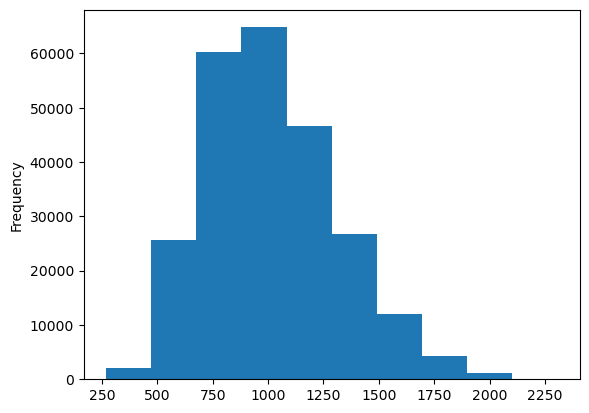

In [33]:
storm_translation.plot.hist()

In [34]:
if mod == 'CM4':
    monthly_dates = xr.cftime_range(start="0151-01-01", end="0650-12-31", freq='MS', calendar='noleap')
if mod == 'ESM4':
    monthly_dates = xr.cftime_range(start="0001-01-01", end="0500-12-31", freq='MS', calendar='noleap')

monthly_centers = np.ones(len(monthly_dates))*np.nan
monthly_tracks = np.ones(len(monthly_dates))*np.nan
monthly_translation = np.ones(len(monthly_dates))*np.nan

for i, date in enumerate(monthly_dates):
    storms_date = df[(df['Month']==date.month) & (df['Year']==date.year)]
    monthly_centers[i] = len(storms_date)
    monthly_tracks[i] = len(storms_date['Event'].unique())
    monthly_translation[i] = storms_date['distance_km'].mean() * 4

In [35]:
ds_out = xr.Dataset(
    data_vars=dict(
        center_counts = (["time"], monthly_centers),
        track_counts = (["time"], monthly_tracks),
        translation_avg = (["time"], monthly_translation),
    ),
    coords=dict(
        time=monthly_dates,
    ),
    attrs=dict(description=f"Monthly storm statistics for {mod} 500-year piControl")
)
ds_out

<xarray.Dataset>
Dimensions:          (time: 6000)
Coordinates:
  * time             (time) object 0001-01-01 00:00:00 ... 0500-12-01 00:00:00
Data variables:
    center_counts    (time) float64 563.0 609.0 795.0 ... 815.0 710.0 742.0
    track_counts     (time) float64 34.0 37.0 53.0 45.0 ... 51.0 51.0 48.0 39.0
    translation_avg  (time) float64 985.8 929.3 1.037e+03 ... 954.2 826.7
Attributes:
    description:  Monthly storm statistics for ESM4 500-year piControl

In [36]:
ds_out.to_netcdf(f'/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{mod}_cmip_monthly_storms.nc')